In [1]:
import zipfile
import os
import numpy as np
import pandas as pd
import json
import numpy as np
from numpy.random import rand
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def unzip_files_in_folder(directory, output_folder=None):
    # If no output folder specified, unzip files in the same directory
    if output_folder is None:
        output_folder = directory

    # List all files in the directory
    for file in os.listdir(directory):
        if file.endswith(".zip"):
            # Construct full file path
            file_path = os.path.join(directory, file)
            # Create a ZipFile object
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                # Extract all the contents into the output directory
                zip_ref.extractall(output_folder)
                print(f"Extracted {file} in {output_folder}")

# Specify the directory containing the zip files
source_directory = '/content/drive/MyDrive/Overture course/Ouverture/'
output_directory = ''  # Optional: specify if different from source_directory
unzip_files_in_folder(source_directory, output_directory)

Extracted MixAll_0024.zip in 


In [4]:
def unzip_files_in_folder(directory, output_folder=None):
    # If no output folder specified, unzip files in the same directory
    if output_folder is None:
        output_folder = directory

    # List all files in the directory
    for file in os.listdir(directory):
        if file == "VeReMi_64800_68400_2022-9-11_12.51.1.zip":
            # Construct full file path
            file_path = os.path.join(directory, file)
            # Create a ZipFile object
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                # Extract all the contents into the output directory
                zip_ref.extractall(output_folder)
                print(f"Extracted {file} in {output_folder}")

# Specify the directory containing the zip files
source_directory = '/content/drive/MyDrive/Overture course/Ouverture/'
output_directory = ''  # Optional: specify if different from source_directory
unzip_files_in_folder(source_directory, output_directory)
# Specify the directory containing the zip files
source_directory = 'MixAll_0024'
output_directory = 'MixAll_0024_unzipped'  # Optional: specify if different from source_directory
unzip_files_in_folder(source_directory, output_directory)

Extracted VeReMi_64800_68400_2022-9-11_12.51.1.zip in MixAll_0024_unzipped


# Import Ground Truth firstly

In [5]:
# Specify the path to your JSON file
file_path = '/content/MixAll_0024_unzipped/VeReMi_64800_68400_2022-9-11_12:51:1/traceGroundTruthJSON-18.json'

# Initialize a list to store JSON objects
json_objects = []

# Open the file and read line by line
with open(file_path, 'r') as file:
    for line in file:
        try:
            # Parse each line as a JSON object and append to list
            json_object = json.loads(line)
            json_objects.append(json_object)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON from line: {line}, Error: {e}")
ground_truth_df = pd.DataFrame(json_objects)
ground_truth_df['messageID'] = ground_truth_df.messageID.astype(int)
columns_to_expand = ['pos', 'pos_noise', 'spd', 'spd_noise', 'acl', 'acl_noise', 'hed', 'hed_noise']
for col in columns_to_expand:
    ground_truth_df[[f'{col}_x', f'{col}_y', f'{col}_z']] = pd.DataFrame(ground_truth_df[col].tolist(), index=ground_truth_df.index)
ground_truth_df.drop(columns=columns_to_expand, inplace=True)

In [6]:
ground_truth_df.head()

,type,sendTime,sender,senderPseudo,messageID,pos_x,pos_y,pos_z,pos_noise_x,pos_noise_y,...,acl_z,acl_noise_x,acl_noise_y,acl_noise_z,hed_x,hed_y,hed_z,hed_noise_x,hed_noise_y,hed_noise_z
0,4,64800.387780,103173,101031736,299503771,267.640989,25.713767,0.0,3.970504,4.237412,...,0.0,0.001494,0.001494,0.0,-0.102790,0.994703,0.0,16.620862,16.620862,0.0
1,4,64800.609704,103167,101031676,299508093,265.116381,50.670492,0.0,3.484334,3.479188,...,0.0,0.002070,0.002070,0.0,-0.102790,0.994703,0.0,16.667649,16.667649,0.0
2,4,64801.387780,103173,101031736,299523606,267.684843,26.855246,0.0,4.429387,4.130480,...,0.0,0.000309,0.002987,0.0,-0.096635,0.995320,0.0,16.967928,13.608172,0.0
3,4,64801.609704,103167,101031676,299527793,265.147251,52.156954,0.0,3.476330,3.593244,...,0.0,0.000569,0.005504,0.0,-0.102790,0.994703,0.0,17.131999,12.775912,0.0
4,4,64801.898907,103179,101031796,299530770,771.496277,762.881287,0.0,3.294000,3.135115,...,0.0,0.000996,0.000421,0.0,-0.232976,0.972483,0.0,3.166041,2.966817,0.0


In [7]:
ground_truth_df.messageID.nunique()

280389

In [8]:
gt_list = [int(row.messageID) for index, row in ground_truth_df.iterrows()]

# Import other files

In [9]:
def read_json_file(file_path):
    data = []  # List to store the selected items
    with open(file_path, 'r') as file:
        for line in file:
            json_obj = json.loads(line)  # Parse the JSON data from the line
            if json_obj['type'] == 3:  # Check if the 'type' is 3
                keys = ["rcvTime","sendTime","sender",'pos', 'pos_noise', 'spd', 'spd_noise', 'acl', 'acl_noise', 'hed', 'hed_noise']
                # For each 3D list (like 'pos', 'spd', etc.), split it into individual components
                for key in ['pos', 'pos_noise', 'spd', 'spd_noise', 'acl', 'acl_noise', 'hed', 'hed_noise']:
                    if key in json_obj:
                        json_obj[f'{key}_x'], json_obj[f'{key}_y'], json_obj[f'{key}_z'] = json_obj[key]
                        del json_obj[key]  # Remove the original key with the list
                data.append(json_obj)  # Add the modified object to the list
    df = pd.DataFrame(data)
    return df

In [18]:
# List to store DataFrames converted to numpy arrays
numpy_arrays = []
client_names = []
messages_ids = []
ground_truths = []
# gt_set = set(gt_list)
directory_path= '/content/MixAll_0024_unzipped/VeReMi_64800_68400_2022-9-11_12:51:1'

In [19]:
revievers_attacks = []
# Iterate over each file in the given directory
for filename in os.listdir(directory_path):
    if filename.endswith('.json') and 'groundtruth' not in filename.lower():  # Check if the file is a JSON file
        revievers_attacks.append((int(filename.split('-')[1]) , filename.split('-')[3]))
receiver_df = pd.DataFrame(revievers_attacks, columns = ['receiver' , 'attack_type'])

In [20]:
# Iterate over each file in the given directory
for filename in os.listdir(directory_path):
    if filename.endswith('.json') and 'groundtruth' not in filename.lower():  # Check if the file is a JSON file
        file_path = os.path.join(directory_path, filename)
        client_names.append(filename)
        df = read_json_file(file_path)  # Read the file and get the DataFrame
        final = pd.merge(df, receiver_df, left_on = 'sender' , right_on = 'receiver', how = 'left')
        numpy_arrays.append(final.to_numpy())  # Convert the DataFrame to a numpy array and add to the list
numpy_array_shapes = [array.shape for array in numpy_arrays]
columns = ['type', 'rcvTime', 'sendTime',
           'sender', 'senderPseudo', 'messageID',
           'pos_x', 'pos_y', 'pos_z',
           'pos_noise_x', 'pos_noise_y', 'pos_noise_z',
           'spd_x', 'spd_y','spd_z',
           'spd_noise_x', 'spd_noise_y', 'spd_noise_z',
           'acl_x', 'acl_y', 'acl_z', 'acl_noise_x',
           'acl_noise_y', 'acl_noise_z',
           'hed_x', 'hed_y', 'hed_z',
           'hed_noise_x','hed_noise_y', 'hed_noise_z',
           'receiver','attack_type']

In [21]:
print('Clients names: ',client_names[:5])
print('Clients shapes: ',numpy_array_shapes[:5])

Clients names:  ['traceJSON-104193-104191-A12-65080-18.json', 'traceJSON-113601-113599-A0-67503-18.json', 'traceJSON-112473-112471-A7-67187-18.json', 'traceJSON-104811-104809-A11-65263-18.json', 'traceJSON-108015-108013-A18-66111-18.json']
Clients shapes:  [(1225, 32), (617, 32), (93, 32), (439, 32), (1611, 32)]


In [31]:
numpy_arrays[0]

array([[3, 65080.03307309835, 65080.03307309835, ..., 0.0, 103713, 'A16'],
       [3, 65080.05635022696, 65080.05635022696, ..., 0.0, 103701, 'A0'],
       [3, 65080.05821710795, 65080.05821710795, ..., 0.0, 104073, 'A14'],
       ...,
       [3, 65169.39036240871, 65169.39036240871, ..., 0.0, 104277, 'A0'],
       [3, 65169.48214949435, 65169.48214949435, ..., 0.0, 104037, 'A0'],
       [3, 65169.5513035778, 65169.5513035778, ..., 0.0, 104403, 'A0']],
      dtype=object)

In [23]:
sum(array.shape[0] for array in numpy_arrays)

2324621

In [41]:
dataframes = []
for array in numpy_arrays:
    df = pd.DataFrame(array, columns=columns)
    dataframes.append(df)

In [42]:
combined_df = pd.concat(dataframes, ignore_index=True)

In [43]:
combined_df.head()

,type,rcvTime,sendTime,sender,senderPseudo,messageID,pos_x,pos_y,pos_z,pos_noise_x,...,acl_noise_y,acl_noise_z,hed_x,hed_y,hed_z,hed_noise_x,hed_noise_y,hed_noise_z,receiver,attack_type
0,3,65080.033073,65080.033073,103713,401037136,303098260,257.480974,219.06015,0.0,4.026279,...,0.000007,0.0,0.040047,-0.999198,0.0,13.252,38.997242,0.0,103713,A16
1,3,65080.05635,65080.05635,103701,101037016,303098710,277.85159,79.572095,0.0,4.994667,...,0.000017,0.0,0.001794,-0.999998,0.0,16.344855,71.910618,0.0,103701,A0
2,3,65080.058217,65080.058217,104073,101040736,303098989,987.073841,1187.327031,0.0,3.273456,...,0.000013,0.0,0.115501,-0.862531,0.0,6.438587,5.530048,0.0,104073,A14
3,3,65080.118642,65080.118642,104091,101040916,303099817,256.591091,148.435602,0.0,3.544975,...,0.000144,0.0,-0.041986,0.999118,0.0,24.025415,4.500996,0.0,104091,A16
4,3,65080.190618,65080.190618,103731,101037316,303101115,259.763089,188.951015,0.0,3.704704,...,0.000113,0.0,0.041396,-0.999143,0.0,12.384118,38.012207,0.0,103731,A7


In [44]:
combined_df.columns

Index(['type', 'rcvTime', 'sendTime', 'sender', 'senderPseudo', 'messageID',
       'pos_x', 'pos_y', 'pos_z', 'pos_noise_x', 'pos_noise_y', 'pos_noise_z',
       'spd_x', 'spd_y', 'spd_z', 'spd_noise_x', 'spd_noise_y', 'spd_noise_z',
       'acl_x', 'acl_y', 'acl_z', 'acl_noise_x', 'acl_noise_y', 'acl_noise_z',
       'hed_x', 'hed_y', 'hed_z', 'hed_noise_x', 'hed_noise_y', 'hed_noise_z',
       'receiver', 'attack_type'],
      dtype='object')

In [45]:
combined_df = combined_df.drop(columns=['sender', 'senderPseudo', 'receiver', 'messageID'])

In [46]:
combined_df.head()

,type,rcvTime,sendTime,pos_x,pos_y,pos_z,pos_noise_x,pos_noise_y,pos_noise_z,spd_x,...,acl_noise_x,acl_noise_y,acl_noise_z,hed_x,hed_y,hed_z,hed_noise_x,hed_noise_y,hed_noise_z,attack_type
0,3,65080.033073,65080.033073,257.480974,219.06015,0.0,4.026279,4.126353,0.0,-0.020157,...,0.000034,0.000007,0.0,0.040047,-0.999198,0.0,13.252,38.997242,0.0,A16
1,3,65080.05635,65080.05635,277.85159,79.572095,0.0,4.994667,4.531754,0.0,1.802302,...,0.000106,0.000017,0.0,0.001794,-0.999998,0.0,16.344855,71.910618,0.0,A0
2,3,65080.058217,65080.058217,987.073841,1187.327031,0.0,3.273456,3.469965,0.0,2.000718,...,0.000002,0.000013,0.0,0.115501,-0.862531,0.0,6.438587,5.530048,0.0,A14
3,3,65080.118642,65080.118642,256.591091,148.435602,0.0,3.544975,3.446924,0.0,-2.41729,...,0.000363,0.000144,0.0,-0.041986,0.999118,0.0,24.025415,4.500996,0.0,A16
4,3,65080.190618,65080.190618,259.763089,188.951015,0.0,3.704704,3.803915,0.0,12.882483,...,0.000105,0.000113,0.0,0.041396,-0.999143,0.0,12.384118,38.012207,0.0,A7


In [48]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

features = combined_df.drop('attack_type', axis=1)
targets = combined_df['attack_type']

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Encode labels
encoder = LabelEncoder()
targets_encoded = encoder.fit_transform(targets)

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(features_scaled, targets_encoded, test_size=0.2, random_state=42)

In [61]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the model
model_ffnn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_train)), activation='softmax')
])

# Compile the model
model_ffnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model architecture
model_ffnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               3584      
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 21)               

In [62]:
history = model_ffnn.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
23247/23247 [==============================] - 83s 4ms/step - loss: 1.2818 - accuracy: 0.6749 - val_loss: 1.0575 - val_accuracy: 0.7173
Epoch 2/10
23247/23247 [==============================] - 80s 3ms/step - loss: 1.1436 - accuracy: 0.7033 - val_loss: 0.9938 - val_accuracy: 0.7350
Epoch 3/10
23247/23247 [==============================] - 80s 3ms/step - loss: 1.1134 - accuracy: 0.7105 - val_loss: 0.9691 - val_accuracy: 0.7389
Epoch 4/10
23247/23247 [==============================] - 79s 3ms/step - loss: 1.0938 - accuracy: 0.7150 - val_loss: 0.9453 - val_accuracy: 0.7465
Epoch 5/10
23247/23247 [==============================] - 79s 3ms/step - loss: 1.0816 - accuracy: 0.7181 - val_loss: 0.9300 - val_accuracy: 0.7525
Epoch 6/10
23247/23247 [==============================] - 79s 3ms/step - loss: 1.0717 - accuracy: 0.7208 - val_loss: 0.9191 - val_accuracy: 0.7552
Epoch 7/10
23247/23247 [==============================] - 79s 3ms/step - loss: 1.0649 - accuracy: 0.7228 - val_loss: 0

In [63]:
test_loss, test_acc = model_ffnn.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

14529/14529 [==============================] - 27s 2ms/step - loss: 0.8977 - accuracy: 0.7596
Test Accuracy: 0.7595999240875244


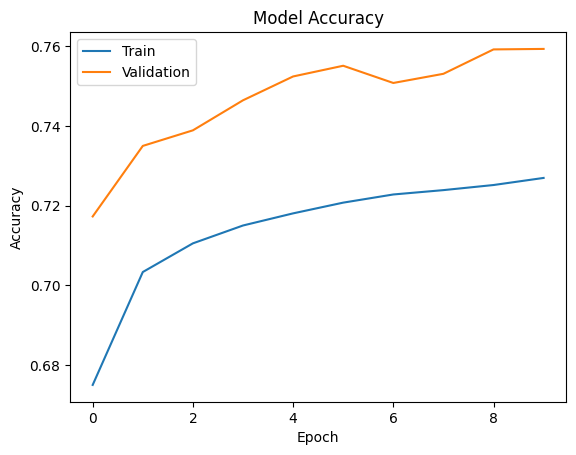

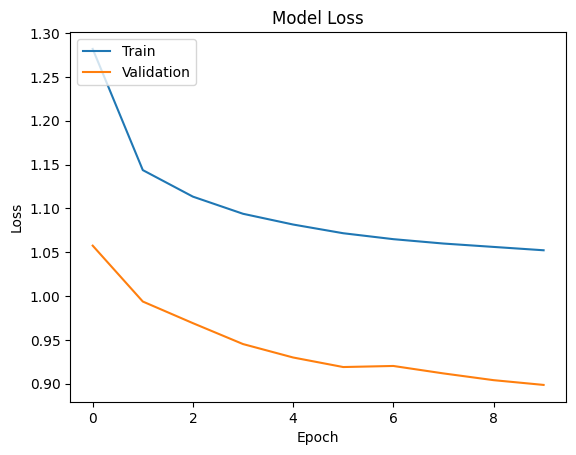

In [64]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [65]:
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model_lstm = Sequential([
    LSTM(50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(50),
    Dropout(0.3),
    Dense(len(np.unique(y_train)), activation='softmax')
])

model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 50)             15600     
                                                                 
 dropout_8 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_9 (Dense)             (None, 21)                1071      
                                                                 
Total params: 36871 (144.03 KB)
Trainable params: 36871 (144.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [67]:
history = model_lstm.fit(X_train_reshaped, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
23247/23247 [==============================] - 123s 5ms/step - loss: 1.2807 - accuracy: 0.6777 - val_loss: 1.0623 - val_accuracy: 0.7187
Epoch 2/10
23247/23247 [==============================] - 119s 5ms/step - loss: 1.1210 - accuracy: 0.7092 - val_loss: 0.9743 - val_accuracy: 0.7389
Epoch 3/10
23247/23247 [==============================] - 121s 5ms/step - loss: 1.0732 - accuracy: 0.7194 - val_loss: 0.9315 - val_accuracy: 0.7513
Epoch 4/10
23247/23247 [==============================] - 119s 5ms/step - loss: 1.0451 - accuracy: 0.7258 - val_loss: 0.8963 - val_accuracy: 0.7619
Epoch 5/10
23247/23247 [==============================] - 119s 5ms/step - loss: 1.0252 - accuracy: 0.7310 - val_loss: 0.8805 - val_accuracy: 0.7662
Epoch 6/10
23247/23247 [==============================] - 119s 5ms/step - loss: 1.0101 - accuracy: 0.7352 - val_loss: 0.8599 - val_accuracy: 0.7720
Epoch 7/10
23247/23247 [==============================] - 120s 5ms/step - loss: 0.9984 - accuracy: 0.7384 - val_

In [68]:
test_loss, test_acc = model_lstm.evaluate(X_test_reshaped, y_test)
print(f'Test Accuracy: {test_acc}')

14529/14529 [==============================] - 36s 2ms/step - loss: 0.8204 - accuracy: 0.7846
Test Accuracy: 0.7845910787582397


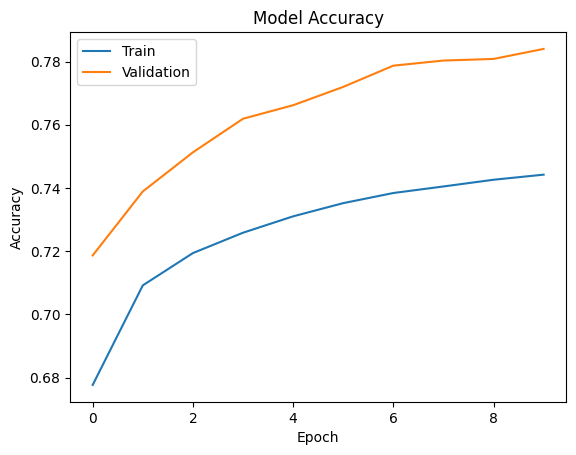

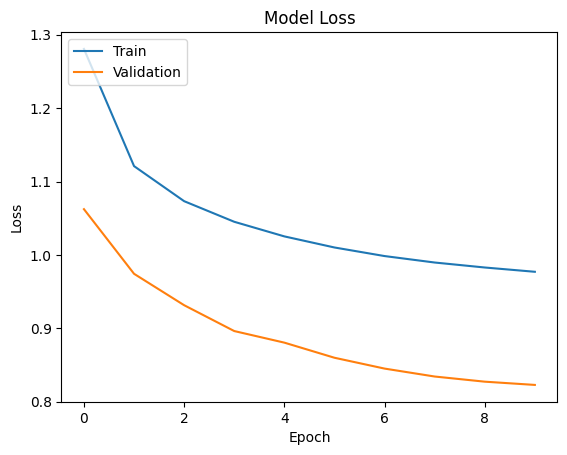

In [69]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [129]:
# For the feedforward neural network
ffnn_predictions = model_ffnn.predict(X_test)
ffnn_pred_classes = np.argmax(ffnn_predictions, axis=1)

# For the LSTM model
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
lstm_predictions = model_lstm.predict(X_test_reshaped)
lstm_pred_classes = np.argmax(lstm_predictions, axis=1)

14529/14529 [==============================] - 29s 2ms/step


In [72]:
from sklearn.metrics import confusion_matrix

# Confusion matrix for the feedforward neural network
ffnn_cm = confusion_matrix(y_test, ffnn_pred_classes)

# Confusion matrix for the LSTM model
lstm_cm = confusion_matrix(y_test, lstm_pred_classes)

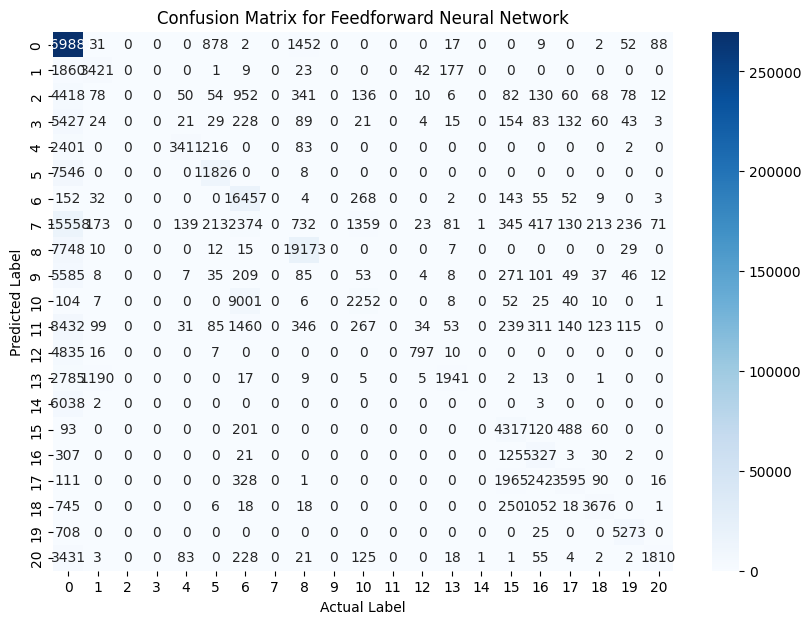

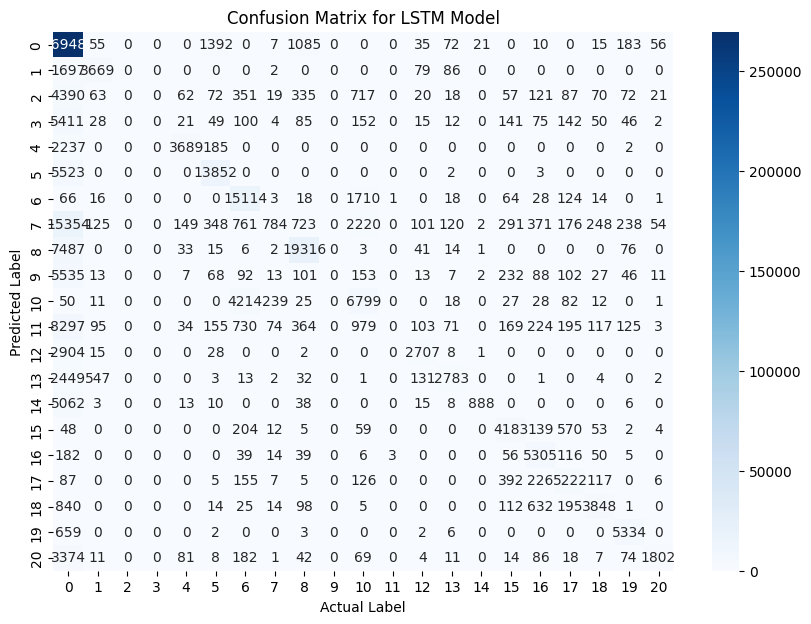

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.ylabel('Predicted Label')
    plt.xlabel('Actual Label')
    plt.show()

# Plotting confusion matrix for the feedforward neural network
plot_confusion_matrix(ffnn_cm, title='Confusion Matrix for Feedforward Neural Network')

# Plotting confusion matrix for the LSTM model
plot_confusion_matrix(lstm_cm, title='Confusion Matrix for LSTM Model')

In [130]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score
precision, recall, f1, score  = precision_recall_fscore_support(y_test, ffnn_pred_classes, average = 'macro')
print(precision, recall, f1)

0.39506715563541034 0.6276417619749809 0.4385821116010275


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [124]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score
precision, recall, f1, score  = precision_recall_fscore_support(y_test, lstm_pred_classes, average = 'macro')
print(precision, recall, f1)

0.6439990611128332 0.5083734738679391 0.5317855025527191


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [75]:
combined_df.attack_type.value_counts()

attack_type
A0     1361066
A16     135202
A15     109991
A13      97210
A14      84677
A19      58831
A18      57570
A10      32430
A17      32206
A11      31458
A7       31406
A12      30870
A4       30853
A3       30303
A9       30148
A8       29411
A6       29102
A2       28373
A1       28085
A5       26563
Name: count, dtype: int64

## Undersampling and oversampling

In [76]:
pip install imbalanced-learn

In [77]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(features_scaled, targets_encoded)
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [78]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(features_scaled, targets_encoded)

# Split the resampled data
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [80]:
model_ffnn.fit(X_train_over, y_train_over, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate on oversampled test data
test_loss, test_acc = model_ffnn.evaluate(X_test_over, y_test_over)
print(f'Oversampled Test Accuracy: {test_acc}')

# Repeat for undersampled data
model_ffnn.fit(X_train_under, y_train_under, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate on undersampled test data
test_loss, test_acc = model_ffnn.evaluate(X_test_under, y_test_under)
print(f'Undersampled Test Accuracy: {test_acc}')

Epoch 1/10
285824/285824 [==============================] - 967s 3ms/step - loss: 1.5579 - accuracy: 0.5114 - val_loss: 1.2165 - val_accuracy: 0.6167
Epoch 2/10
285824/285824 [==============================] - 959s 3ms/step - loss: 1.5201 - accuracy: 0.5251 - val_loss: 1.1956 - val_accuracy: 0.6221
Epoch 3/10
285824/285824 [==============================] - 960s 3ms/step - loss: 1.5066 - accuracy: 0.5300 - val_loss: 1.1843 - val_accuracy: 0.6252
Epoch 4/10
 63966/285824 [=====>........................] - ETA: 10:59 - loss: 1.5003 - accuracy: 0.5320

KeyboardInterrupt: 

In [83]:
# Repeat for undersampled data
model_ffnn.fit(X_train_under, y_train_under, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate on undersampled test data
test_loss, test_acc = model_ffnn.evaluate(X_test_under, y_test_under)
print(f'Undersampled Test Accuracy: {test_acc}')

Epoch 1/10
5579/5579 [==============================] - 127s 23ms/step - loss: 1.5002 - accuracy: 0.5321 - val_loss: 1.1827 - val_accuracy: 0.6262
Epoch 2/10
5579/5579 [==============================] - 126s 23ms/step - loss: 1.4988 - accuracy: 0.5332 - val_loss: 1.1809 - val_accuracy: 0.6300
Epoch 3/10
5579/5579 [==============================] - 126s 23ms/step - loss: 1.4988 - accuracy: 0.5330 - val_loss: 1.1853 - val_accuracy: 0.6248
Epoch 4/10
5579/5579 [==============================] - 126s 23ms/step - loss: 1.4966 - accuracy: 0.5335 - val_loss: 1.1820 - val_accuracy: 0.6202
Epoch 5/10
5579/5579 [==============================] - 126s 23ms/step - loss: 1.4986 - accuracy: 0.5334 - val_loss: 1.1818 - val_accuracy: 0.6260
Epoch 6/10
5579/5579 [==============================] - 126s 23ms/step - loss: 1.4996 - accuracy: 0.5332 - val_loss: 1.1932 - val_accuracy: 0.6233
Epoch 7/10
5579/5579 [==============================] - 126s 23ms/step - loss: 1.4944 - accuracy: 0.5340 - val_loss: 1

In [143]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score
precision, recall, f1, score  = precision_recall_fscore_support(y_test_under, ffnn_pred_classes_under, average = 'macro')
print(precision, recall, f1)

0.5694520049133771 0.6276202038075185 0.5771319326967544


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [134]:
y_test_under

array([18, 15, 11, ..., 16, 17, 10])

In [137]:
ffnn_predictions_under

array([[1.79945845e-02, 8.25721491e-03, 4.02193926e-02, ...,
        7.06442416e-01, 8.17708671e-03, 2.19125277e-03],
       [1.06846377e-19, 5.30973859e-20, 1.54403765e-02, ...,
        2.61242210e-04, 5.08645071e-11, 8.31759477e-04],
       [1.63937464e-01, 4.38890094e-03, 1.28275692e-01, ...,
        4.31800494e-04, 4.36028186e-03, 1.23942411e-03],
       ...,
       [1.21410228e-02, 2.50938023e-03, 1.90954562e-02, ...,
        6.33044615e-02, 1.91579305e-03, 1.44534768e-03],
       [4.00958368e-34, 1.07755574e-35, 3.53189372e-02, ...,
        1.75901418e-10, 2.25929454e-18, 2.78289174e-03],
       [4.10547739e-34, 0.00000000e+00, 2.91439798e-02, ...,
        4.47723308e-23, 2.03607840e-24, 1.11699212e-10]], dtype=float32)

In [138]:
X_test_under

array([[ 0.        ,  0.00755985,  0.00755985, ...,  3.25721548,
         0.49229052,  0.        ],
       [ 0.        , -1.31369294, -1.31369294, ...,  0.33503348,
        -0.70428044,  0.        ],
       [ 0.        ,  1.05052165,  1.05052165, ..., -0.51211626,
         0.40578306,  0.        ],
       ...,
       [ 0.        , -0.4121438 , -0.4121438 , ...,  0.9797457 ,
         1.30032722,  0.        ],
       [ 0.        ,  0.13606907,  0.13606907, ..., -0.82262654,
        -0.86778358,  0.        ],
       [ 0.        ,  0.26218196,  0.26218196, ..., -0.4741245 ,
         3.10955532,  0.        ]])

In [140]:
# For the feedforward neural network
ffnn_predictions_under = model_ffnn.predict(X_test_under)
ffnn_pred_classes_under = np.argmax(ffnn_predictions_under, axis=1)

3487/3487 [==============================] - 5s 1ms/step


In [141]:
# Confusion matrix for the feedforward neural network
ffnn_cm_under = confusion_matrix(y_test_under, ffnn_pred_classes_under)

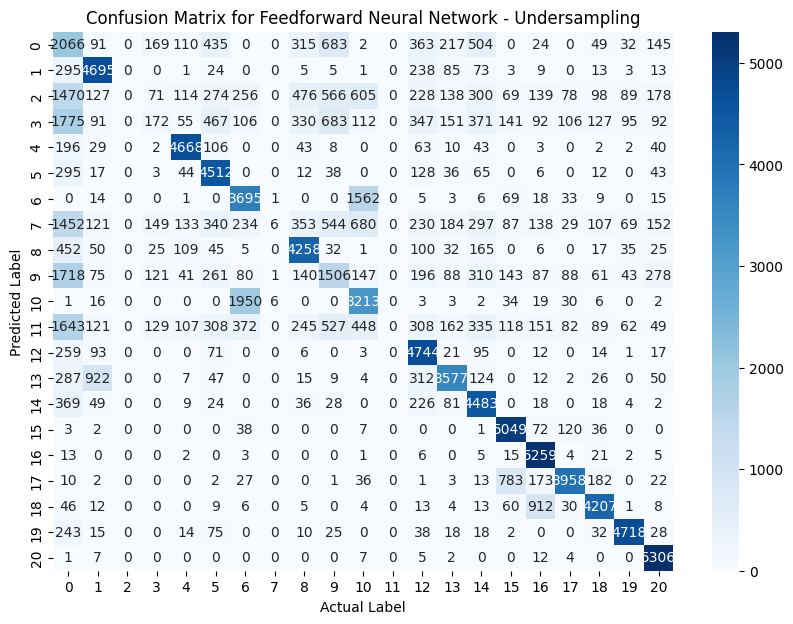

In [142]:
# Plotting confusion matrix for the feedforward neural network
plot_confusion_matrix(ffnn_cm_under, title='Confusion Matrix for Feedforward Neural Network - Undersampling')

In [95]:
X_train_reshaped_under = X_train_under.reshape(X_train_under.shape[0], 1, X_train_under.shape[1])
X_test_reshaped_under = X_test_under.reshape(X_test_under.shape[0], 1, X_test_under.shape[1])

In [97]:
model_lstm.fit(X_train_reshaped_under, y_train_under, epochs=10, batch_size=64, validation_split=0.2)
# Evaluate on undersampled test data
test_loss, test_acc = model_lstm.evaluate(X_test_reshaped_under, y_test_under)
print(f'Undersampled Test Accuracy: {test_acc}')

Epoch 1/10
5579/5579 [==============================] - 29s 5ms/step - loss: 1.4240 - accuracy: 0.5543 - val_loss: 1.1108 - val_accuracy: 0.6517
Epoch 2/10
5579/5579 [==============================] - 29s 5ms/step - loss: 1.4225 - accuracy: 0.5546 - val_loss: 1.1081 - val_accuracy: 0.6509
Epoch 3/10
5579/5579 [==============================] - 29s 5ms/step - loss: 1.4207 - accuracy: 0.5550 - val_loss: 1.1064 - val_accuracy: 0.6532
Epoch 4/10
5579/5579 [==============================] - 29s 5ms/step - loss: 1.4166 - accuracy: 0.5570 - val_loss: 1.1021 - val_accuracy: 0.6544
Epoch 5/10
5579/5579 [==============================] - 30s 5ms/step - loss: 1.4152 - accuracy: 0.5578 - val_loss: 1.1002 - val_accuracy: 0.6536
Epoch 6/10
5579/5579 [==============================] - 30s 5ms/step - loss: 1.4126 - accuracy: 0.5586 - val_loss: 1.0990 - val_accuracy: 0.6551
Epoch 7/10
5579/5579 [==============================] - 29s 5ms/step - loss: 1.4093 - accuracy: 0.5590 - val_loss: 1.0956 - val_ac

In [98]:
# For the feedforward neural network
lstm_predictions_under = model_lstm.predict(X_test_reshaped_under)
lstm_pred_classes_under = np.argmax(lstm_predictions_under, axis=1)

3487/3487 [==============================] - 7s 2ms/step


In [144]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score
precision, recall, f1, score  = precision_recall_fscore_support(y_test_under, lstm_pred_classes_under, average = 'macro')
print(precision, recall, f1)

0.6148748427019582 0.6549696829674941 0.6095795093635105


In [99]:
# Confusion matrix for the feedforward neural network
lstm_cm_under = confusion_matrix(y_test_under, lstm_pred_classes_under)

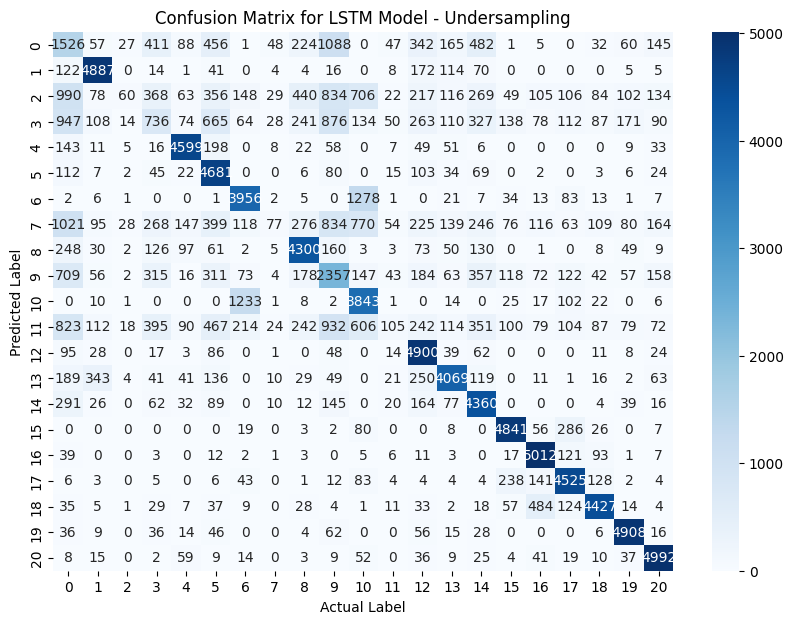

In [107]:
# Plotting confusion matrix for the feedforward neural network
plot_confusion_matrix(lstm_cm_under, title='Confusion Matrix for LSTM Model - Undersampling')

In [109]:
# Calculating micro-average precision and recall
TP_total = np.sum(np.diag(lstm_cm_under))  # Sum of diagonal elements
FP_total = np.sum(np.sum(lstm_cm_under, axis=0) - np.diag(lstm_cm_under))  # Sum of each column minus its diagonal
FN_total = np.sum(np.sum(lstm_cm_under, axis=1) - np.diag(lstm_cm_under))  # Sum of each row minus its diagonal

# Micro-average Precision and Recall
micro_precision = TP_total / (TP_total + FP_total) if (TP_total + FP_total) > 0 else 0
micro_recall = TP_total / (TP_total + FN_total) if (TP_total + FN_total) > 0 else 0

print("Micro-average Precision of FFNN undersampling:", micro_precision)
print("Micro-average Recall of FFNN undersampling:", micro_recall)

Micro-average Precision of FFNN undersampling: 0.6557701788195223
Micro-average Recall of FFNN undersampling: 0.6557701788195223
